In [1]:
import os
import json
import pandas as pd
import time
import re
from collections import Counter
import random
import numpy as np
import tensorflow as tf

In [2]:
with open('config.json') as conf_file:
    config = json.load(conf_file)

In [3]:
#list all files path for the selected dataset

def get_file_list(dataset):
    file_path_list = []
    for root, dirs, files in os.walk(config[dataset]):
         for file in files:
                file_path_list.append(os.path.join(root, file))

    print("file path list created, ", len(file_path_list), " files")
    return file_path_list



In [67]:
# Datasets:
# path_reuters_sample_5d  -- 5 Days of articles, 79 articles
# path_reuters_sample_1y -- 1y of articles, approx. 12k articles
# path_reuters  -- Full dataset +- approx. 100k articles

file_path_list = get_file_list('path_reuters_sample_1y')

file path list created,  11783  files


In [68]:
def preprocess_text(text):

    text = text.lower()
    #text = re.sub('[^a-z\d ]+', ' ', text) #remove special characters
    text = re.sub('[^a-z ]+', ' ', text) # replace with space to avoid concatenating words
    text = re.sub(' +', ' ', text) # remove multiple spaces
    # TODO: replace numbers with tag <NUMBER> instead of removing them
    return text
    
    

In [69]:
#function to load news articles into a dataframe

def read_reuters_pandas(file_path_list):
    reuters_articles = pd.DataFrame(columns=['Title','Author', 'Date', 'URL',  'Content'])

    start_t = time.time()
    for i, file_path in enumerate(file_path_list):
        if i%1000 == 0: 
            new_t = time.time()
            # print(i, " files loaded in ", new_t - start_t, " seconds")
            start_t = new_t
        with open(os.path.join(file_path), "r") as current_file:
                    data = current_file.readlines()
                    if len(data) < 4:
                        pass
                    else:
                        title= [preprocess_text(data[0])]
                        author = [re.sub('by', '', preprocess_text(data[1]))]
                        date = [data[2]]
                        url = [data[3]]
                        content = [" ".join(list(map(preprocess_text, data[4:len(data)])))]
                        data=list(map(preprocess_text, current_file.readlines()))
                        new_article = pd.DataFrame(data={'Title': title, 
                                                         'Author': author,
                                                         'Date': date, 
                                                         'URL': url,
                                                         'Content': content})
                        reuters_articles = reuters_articles.append(new_article)
    return reuters_articles

In [7]:
example_list_5d = get_file_list('path_reuters_sample_5d')
reuters_articles_example = read_reuters_pandas(example_list_5d)
reuters_articles_example.head()             

file path list created,  79  files


,Author,Content,Date,Title,URL
0,yereth rosen,anchorage alaska reuters exxon mobil xo...,"-- Fri Oct 20, 2006 6:15pm EDT\n",exxon mobil offers plan to end alaska dispute,-- http://www.reuters.com/article/2006/10/20/b...
0,eric auchard and paul thomasch,san francisco new york reuters wall str...,"-- Fri Oct 20, 2006 4:25pm EDT\n",hey buddy can you spare for a google share,-- http://www.reuters.com/article/2006/10/20/b...
0,,frankfurt reuters internet service prov...,"-- Sat Oct 21, 2006 2:21pm EDT\n",aol ceo says sales may shrink for two years p...,-- http://www.reuters.com/article/2006/10/21/b...
0,alister bull,washington reuters the central bank is ...,"-- Sun Oct 22, 2006 12:14pm EDT\n",fed to keep hawkish tone hold rates steady,-- http://www.reuters.com/article/2006/10/22/b...
0,,lima peru reuters argentine oil company...,"-- Sat Oct 21, 2006 8:11pm EDT\n",pluspetrol says losing mln day in peru protest,-- http://www.reuters.com/article/2006/10/22/b...


In [8]:
# code used to save a dataset with 1y of articles
# import pickle

# pickle.dump( reuters_articles, open( "reuters_articles.p", "wb" ) )

Checkpoint Dataset:

In [9]:
# code used to load a dataset with 1y of articles
# import pickle

# reuters_articles = pickle.load( open( "reuters_articles.p", "rb" ) )

# get wordcount

Function below will count the word frequencies over all articles in the selected list


In [70]:
batch_size = 5000 #number of files to read at once.

wordcount = Counter()

for idx in range(0, len(file_path_list), batch_size):
    print(idx, " ", )
    file_path_sublist = file_path_list[idx:idx+batch_size]
    articles_df = read_reuters_pandas(file_path_sublist)
    
    word_list = "".join(articles_df['Content'].values).split() 
    wordcount = wordcount + Counter(word_list)

0  
5000  
10000  


In [71]:
len(set(list(wordcount)))

45073

In [72]:
# saving wordcount after full load. Uncomment to overwrite
import pickle

#pickle.dump( wordcount, open( "reuters_wordcount.p", "wb" ) )

### Wordcount checkpoint
Load previously saved wordcount here to avoid re-calculating

In [73]:
# code used to load a dataset with 1y of articles
import pickle
 
#wordcount = pickle.load( open( "reuters_wordcount.p", "rb" ) )

In [74]:
wordcount["the"]

242211

## Trimming vocabulary
Removal of most or least frequent words. Using absolute frequencies and random subsampling

In [75]:
#Sub Sampling + removal of least common
def trim_vocabulary(wordcount, lower_bound = 10, threshold = 1e-5):
    # lower_bound = minimal occurences 
    # threshold = sub sampling threshold value
    
    print("Vocabulary size before trimming: ", len(wordcount.items()))

    total_count = sum(wordcount.values())

    freqs = {word: count/total_count for word, count in wordcount.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in wordcount}
    
    vocabulary = [word for word in list(wordcount) if wordcount[word] > lower_bound and random.random() < (1 - p_drop[word])]
    
    print("Vocabulary size after trimming: ", len(vocabulary))

    return vocabulary
    

In [76]:
vocabulary = trim_vocabulary(wordcount)

Vocabulary size before trimming:  45073
Vocabulary size after trimming:  11048


In [28]:


#pickle.dump( vocabulary, open( "vocabulary29012018.p", "wb" ) )

In [77]:
#vocabulary = pickle.load( open( "vocabulary29012018.p", "rb" ) )

In [78]:
sorted_vocab = sorted(vocabulary, key=wordcount.get, reverse=True)
int_to_vocab = {idx: word for idx, word in enumerate(sorted_vocab)}
vocab_to_int = {word: idx for idx, word in int_to_vocab.items()}

int_words = [vocab_to_int[word] for word in vocabulary]

print("most common words: ", sorted_vocab[1:20])

most common words:  ['that', 'be', 'quarter', 'bank', 't', 'two', 'investors', 'earlier', 'time', 'exchange', 'analyst', 'when', 'his', 'cut', 'still', 'china', 'states', 'buy', 'our']


# Neural Net graph for Skip-Gram architecture
Skip-Gram approach to word embeddings
## Helper functions:

In [219]:
# get training words for a given batch

def get_train_words(vocabulary, vocab_to_int, file_path_list):
    articles_df = read_reuters_pandas(file_path_list)    
    word_list = "".join(articles_df['Content'].values).split()
    
    match_dict = {word: 1 for word in vocabulary} # waaaay more efficient than "if word in vocabulary"    
    train_words = [vocab_to_int[word] for word in word_list if match_dict.get(word, 0) == 1]
      
    # print("Total words in training set: ", len(train_words))
    # print("Unique words in training set: ", len(set(train_words)))
    
    return train_words

In [80]:
# random window size for target words
def target_words(word_vec, idx, window_size=10):
    rand_window = np.random.randint(1, window_size+1)
    start = max(0, idx - rand_window)
    stop = idx + rand_window
    target_words = set(word_vec[start:idx] + word_vec[idx+1:stop+1])
    
    return list(target_words)

In [81]:
# training batches from set of words
def word_batches(words, batch_size, window_size=5):
    
    n_batches = len(words)//batch_size
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = target_words(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

## Model architecture


In [82]:
n_vocab = len(int_to_vocab)
n_embedding = 200 
train_graph = tf.Graph()
n_sampled = 100

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')
    
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [85]:
def train_function():
    iteration = 1
    loss = 0

    for e in range(1, epochs+1):
        batches = word_batches(train_words, word_batch_size, window_size)
        start = time.time()
        for x, y in batches:  
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)  
            loss += train_loss
            
            out_period = 1000 
            
            if iteration % out_period == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/out_period),
                      "{:.4f} sec/batch".format((end-start)/out_period))
                loss = 0
                start = time.time()
            
            iteration += 1

# Model Training
This can take long

In [86]:
epochs = 10
word_batch_size = 1000
window_size = 10
article_batch_size = 5000 #number of files to read at once.
train_list = file_path_list #random.sample(file_path_list, 5000)

tr_start_time = time.time()
with tf.Session(graph=train_graph) as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    for idx in range(0, len(train_list), article_batch_size):
        print("Article batch :", idx)
        file_path_sublist = file_path_list[idx:idx+article_batch_size]
        train_words = get_train_words(vocabulary, vocab_to_int, file_path_sublist)
        train_function()
        save_path = saver.save(sess, "checkpoints/text_full_reuters2.ckpt")


print("total training time:", time.time()-tr_start_time)


Article batch : 0
Epoch 3/10 Iteration: 1000 Avg. Training loss: 5.2895 0.0051 sec/batch
Epoch 5/10 Iteration: 2000 Avg. Training loss: 4.5520 0.0102 sec/batch
Epoch 8/10 Iteration: 3000 Avg. Training loss: 4.3740 0.0026 sec/batch
Epoch 10/10 Iteration: 4000 Avg. Training loss: 4.2497 0.0075 sec/batch
Article batch : 5000
Epoch 3/10 Iteration: 1000 Avg. Training loss: 4.4851 0.0064 sec/batch
Epoch 5/10 Iteration: 2000 Avg. Training loss: 4.3087 0.0112 sec/batch
Epoch 8/10 Iteration: 3000 Avg. Training loss: 4.2077 0.0016 sec/batch
Epoch 10/10 Iteration: 4000 Avg. Training loss: 4.1370 0.0069 sec/batch
Article batch : 10000
Epoch 7/10 Iteration: 1000 Avg. Training loss: 4.2564 0.0043 sec/batch
total training time: 367.15068650245667


1000


In [49]:
with train_graph.as_default():
    saver = tf.train.Saver()
with tf.Session(graph=train_graph) as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    saver.restore(sess,  "checkpoints/text_full_reuters2.ckpt")
    embed_mat = sess.run(embedding)
    

    

INFO:tensorflow:Restoring parameters from checkpoints/text_full_reuters2.ckpt


In [104]:
print(vocab_to_int['budget'])

536


# Results: Word proximity 
Distance between words show that we have identified words that are related to each other

In [105]:
with train_graph.as_default():
    saver = tf.train.Saver()
    valid_examples = np.array([126, 589, 280,295,68,175,536])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess,  "checkpoints/text_full_reuters2.ckpt")
    embed_mat = sess.run(embedding)
    sim = similarity.eval()
    for i in range(len(valid_examples)):  #len(valid_examples)
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)

INFO:tensorflow:Restoring parameters from checkpoints/text_full_reuters2.ckpt
Nearest to computer: pcs, installed, computing, virtualization, software, yaris, packard, microsystems,
Nearest to myspace: networking, social, facebook, photos, unlock, developers, blogs, matrix,
Nearest to uk: pounds, england, gerard, lloyds, enlarged, pledging, truckers, quoting,
Nearest to ratings: grade, baa, agency, collateralized, collateral, bottoming, abusive, types,
Nearest to google: search, mapping, goog, silicon, links, ad, auchard, baidu,
Nearest to payments: reset, payment, lump, delinquencies, loads, universities, homeowners, documentation,
Nearest to budget: credits, tax, bonanza, ticked, outsold, healthsouth, allegations, defect,


In [88]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [89]:

viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

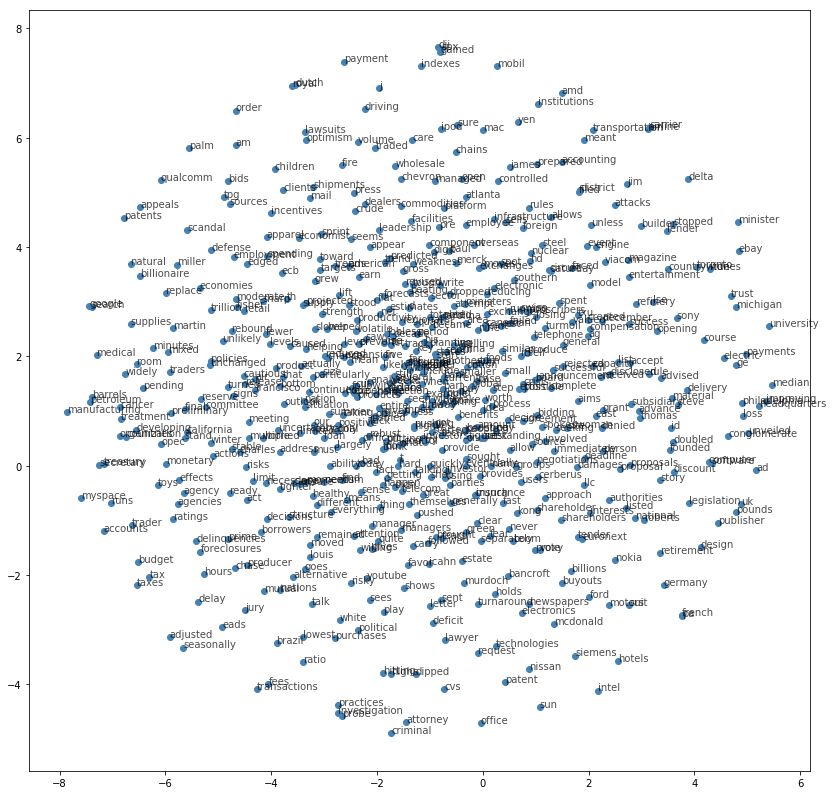

In [90]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# Apply word embeddings to title clustering
We calculate the average embedding for each article title, we then cluster these average embeddings.

Difficult to identify the cluster meaning


In [ ]:
reuters_articles = read_reuters_pandas(file_path_list)

In [107]:
title_list = reuters_articles['Title'].values
title_list_words = [x.split() for x in title_list]
title_list_words

[['exxon', 'mobil', 'offers', 'plan', 'to', 'end', 'alaska', 'dispute'],
 ['hey', 'buddy', 'can', 'you', 'spare', 'for', 'a', 'google', 'share'],
 ['aol',
  'ceo',
  'says',
  'sales',
  'may',
  'shrink',
  'for',
  'two',
  'years',
  'paper'],
 ['fed', 'to', 'keep', 'hawkish', 'tone', 'hold', 'rates', 'steady'],
 ['pluspetrol', 'says', 'losing', 'mln', 'day', 'in', 'peru', 'protest'],
 ['eu', 'to', 'urge', 'china', 'to', 'open', 'economy', 'further'],
 ['daimlerchrysler', 'talks', 'to', 'firms', 'on', 'small', 'car', 'paper'],
 ['weatherford', 'profit', 'jumps', 'percent'],
 ['australia', 's', 'foster', 's', 'says', 'confident', 'on', 'targets'],
 ['update',
  'wal',
  'mart',
  'to',
  'slow',
  'u',
  's',
  'expansion',
  'spending',
  'growth'],
 ['ford', 'posts', 'biggest', 'loss', 'in', 'years'],
 ['ford', 'ceo', 'jury', 'out', 'on', 'european', 'premium', 'brands'],
 ['ford', 'won', 't', 'sell', 'ford', 'credit'],
 ['ford', 'is', 'reviewing', 'all', 'products', 'brands', 'ceo

In [144]:
def average_embeddings(word_list):
    int_word_list = [vocab_to_int.get(word, None) for word in word_list]
    embed_list = [embed_mat[idx] for idx in int_word_list if idx != None]
    mean_vec = np.mean(embed_list, axis=0)
    return   mean_vec#mean_vec[np.logical_not(np.isnan(mean_vec))]
    

In [145]:
avg_embedding_vec = np.array(list(map(average_embeddings, title_list_words)))

D:\anaconda3\envs\tf-gpu-keras\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda3\envs\tf-gpu-keras\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [162]:
mask =[True if type(vec)==np.ndarray else False for vec in avg_embedding_vec]

In [167]:
title_list_select = title_list[mask]
avg_embedding_vec_select = avg_embedding_vec[mask]

In [190]:
np.array(avg_embedding_vec_select).dtype

dtype('O')

In [202]:
#Suuuuuper ugly, suuuuper inefficient, but it is 9pm and I'm sick and tired of fighting with numpy array type conversions

filtered_embed = avg_embedding_vec_select[0].reshape(1,200)
for idx in range(len(avg_embedding_vec_select)-1):
    filtered_embed = np.append(filtered_embed, avg_embedding_vec_select[idx].reshape(1,200), axis=0)



In [203]:
len(avg_embedding_vec_select)-1

11029

In [204]:
filtered_embed.shape

(11030, 200)

In [205]:
from sklearn.cluster import KMeans

n_clusters= 4

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(filtered_embed)
title_group = kmeans.labels_

In [207]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, filtered_embed)

In [208]:
closest

array([3865, 7238, 6536, 1884], dtype=int64)

In [218]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(kmeans.cluster_centers_, filtered_embed)

n_nearest = 5
for i in range(n_clusters):
    sorted_dist_arg = np.argsort(distances[i,:])
    print("Nearest articles to center ", i, ":")
    for k in range(n_nearest):
        print(title_list_select[sorted_dist_arg[k]])
    

Nearest articles to center  0 :
 china markets react calmly to hike 
 couple charged with dj insider trades 
 alcoa nd quarter profit slips extends alcan offer 
 jobs data asian marts to call stocks tune 
 s korea u s investigating samsung lg philips 
Nearest articles to center  1 :
 ici rejects bln akzo nobel bid approach 
 home builder stocks rise on strong sales report 
 tiffany same store sales up pct outlook raised 
 wendy s th quarter net down percent 
 premier league soccer sues youtube over copyright 
Nearest articles to center  2 :
 paulson presses china on yuan flexibility 
 home builder stocks rise on strong sales report 
 big see flat u s auto market 
 starbucks first quarter profit up percent 
 cvs net income rises pct 
Nearest articles to center  3 :
 home builder stocks rise on strong sales report 
 no turkey georgia gas deal yet turkish official 
 wells fargo nd qtr profit rises 
 paulson presses china on yuan flexibility 
 cna returns to profit 


array([[ 6.52117252,  6.52117252,  5.99878025, ...,  4.99174595,
         4.47569561,  6.35454035],
       [ 6.24440861,  6.24440861,  5.63721561, ...,  4.34342098,
         3.123703  ,  5.09884691],
       [ 6.02911806,  6.02911806,  5.17645025, ...,  3.97649908,
         3.51010776,  5.57337952],
       [ 5.99739599,  5.99739599,  5.21960115, ...,  4.07702732,
         3.73301792,  5.67055082]], dtype=float32)

In [220]:
n_titles_print = 6

for idx_a in range(n_clusters):
    print("examples of titles for group ", idx_a+1)
    titles_cluster = [title for idx_b, title in enumerate(title_list_select) if title_group[idx_b] == idx_a ]
    rand_select_title = np.take(titles_cluster, np.random.choice(len(titles_cluster), n_titles_print))
    for title in rand_select_title:
        print(title)


examples of titles for group  1
 late payments up on home loans down on credit cards 
 biomet circled by buyout firms paper 
 u s calls for freer yuan as economic powers meet 
 china markets react calmly to hike 
 volkswagen recalls just over passats 
 delphi investor bloc sign billion equity deal 
examples of titles for group  2
 miners at chile s collahuasi strike copper firms 
 adviser says ford to sell aston martin to investor group 
 lear posts profit on strength outside n america 
 wal mart says hiring execs to evaluate store formats 
 wall st rises on m a 
 exxon plans new projects in next three years 
examples of titles for group  3
 hsbc says private banking little hit by crisis paper 
 comverse says receives letter of default 
 seagate sees sustained double digit revenue growth 
 nasdaq names michael oxley vice chairman 
 payrolls post first decline in years 
 dell to restate years of results after audit ends 
examples of titles for group  4
 abn set to drop barclays recommen